In [1]:
import astropy.units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from divtel.telescope import Telescope, Array 

In [2]:
file = open("../layout-3AL4M15-5.txt", "r")

tels = []
for line in file:  
    #split the string on whitespace, return a list of numbers as strings
    coord_str = line.split()
    coord_str[0], coord_str[1], coord_str[2] = float(coord_str[0]), float(coord_str[1]), float(coord_str[2]) 
    coord = [x*u.m for x in coord_str]
   
    tel = Telescope(coord[0],coord[1],coord[2],coord[3],coord[4])
    tels.append(tel)
    
array = Array(tels)     
#forse non serve generare la classe array a questo punto perchè infondo nella 
#prima fase mi servono solo i telescopi. Se hanno tutti gli attributi necessari 
#non vale la pena creare oggetti inutili


for tel in array.telescopes:
    print(tel.id)
   

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


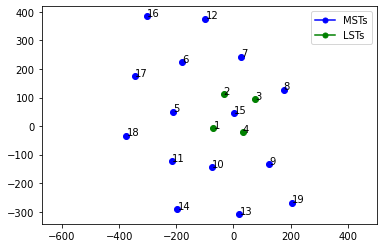

In [3]:
#array layout plot
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker='o', color='blue',markerfacecolor='blue', markersize=5),
                Line2D([0], [0], marker='o', color='g', markerfacecolor='g', markersize=5)]

for i,tel in enumerate(array.telescopes):
    
    plt.annotate(tel.id, (array.positions_array[i,0],array.positions_array[i,1]))
    if i <= 3:
        plt.scatter(array.positions_array[i,0], array.positions_array[i,1], color='green',label='LSTs')
    else:
        plt.scatter(array.positions_array[i,0], array.positions_array[i,1],color='blue',label='MSTs')

plt.axis('equal');
plt.legend(custom_lines, ['MSTs','LSTs']);

# Defining subarrays
I define some groups of telescopes and generate a new array of fake telescopes, each of which is located in  'center of gravity' of the corresponding subarray. 
In this first step divergence is set to 0 but it is a useless parameter, I just need positions on the ground. 


In [4]:
# I create a dictionary containing tel_ids associated to each subarray
groups={'1': np.array([5,17,18]), 
        '2': np.array([10,11,14]),
        '3': np.array([7,15,8]), 
        '4' : np.array([9,13,19]),
        '5':np.array([6,12,16])}


# I define a dictionary containing telescopes positions. This will be used for plot purposes only
group_pos ={'1':np.empty(shape=(3,3)),
            '2':np.empty(shape=(3,3)), '3':np.empty(shape=(3,3)), 
            '4':np.empty(shape=(3,3)), '5': np.empty(shape=(3,3))} 



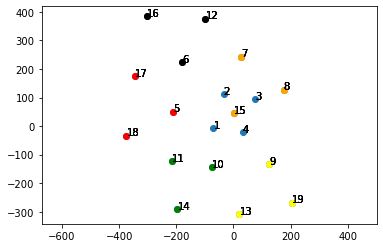

In [5]:
# Checking telescope groups

plt.scatter(array.positions_array[:,0],array.positions_array[:,1] )
for j in groups.keys():
  #print (j)
  for i,tel in enumerate(array.telescopes):
      #print (i, tel.id)
    plt.annotate(tel.id, (array.positions_array[i,0],array.positions_array[i,1]))
    for k, ids in enumerate(groups[j]) :
        #print (k, ids)
        if tel.id == ids:
            group_pos[j][k,:]= array.positions_array[i,:].copy()

plt.scatter(group_pos['1'][:,0],group_pos['1'][:,1], color='red' );
plt.scatter(group_pos['2'][:,0],group_pos['2'][:,1], color='green' )
plt.scatter(group_pos['3'][:,0],group_pos['3'][:,1], color='orange' )
plt.scatter(group_pos['4'][:,0],group_pos['4'][:,1], color='yellow' )
plt.scatter(group_pos['5'][:,0],group_pos['5'][:,1], color='black' )
plt.axis('equal');

In [6]:
# In the previous step I had a dictionary with ids. 
# I now create a dictionary containing telescope objects corresponding to previously selected ids

sub_tels={'0':[]}

# Subarray of LSTs 
for i,tel in enumerate(array.telescopes): 

    if i < 4: 
        #print (tel.id)      
        sub_tels['0'].append(tel)

# Subarrays with MSTs - as defined above

for i in groups.keys():
    sub_tels[i]=[]
    for j in range(len(groups[i])):
        m=groups[i][j]
        
        sub_tels[i].append(tels[m-1])   



In [7]:
# sub_arrays contains the center of gravity coordinates of each subarray

sub_arrays={}

fake_array=np.empty(shape=(len(sub_tels.keys()),3))
for i in range(len(sub_tels.keys())):
    sub_arrays[f'{i}']=Array(sub_tels[f'{i}'])
    print (sub_arrays[f'{i}'].barycenter)
    fake_array[i]=sub_arrays[f'{i}'].barycenter

[ 0.895  44.8475 44.925 ]
[-310.21333333   64.04         74.3       ]
[-161.97333333 -185.64         71.8       ]
[ 68.37666667 138.77        27.5       ]
[ 116.52333333 -236.67         55.3       ]
[-193.34        328.02333333   22.03333333]


Next step is to add focal lenght and camera radius information to these fake telescopes:

In [8]:
# MSTs focal lenght 
fake_array= np.hstack((fake_array, 16*np.ones((fake_array.shape[0], 1))))
# MSTs camera radius
fake_array= np.hstack((fake_array, 3.85*np.ones((fake_array.shape[0], 1))))                                      

# LSTs focal lenght and radius

fake_array[0,3]=28
fake_array[0,4]=2.15

In [9]:
# checking my new telescopes
fake_array

array([[   0.895     ,   44.8475    ,   44.925     ,   28.        ,
           2.15      ],
       [-310.21333333,   64.04      ,   74.3       ,   16.        ,
           3.85      ],
       [-161.97333333, -185.64      ,   71.8       ,   16.        ,
           3.85      ],
       [  68.37666667,  138.77      ,   27.5       ,   16.        ,
           3.85      ],
       [ 116.52333333, -236.67      ,   55.3       ,   16.        ,
           3.85      ],
       [-193.34      ,  328.02333333,   22.03333333,   16.        ,
           3.85      ]])

I will now create an Array object with my new telescopes. This is the array which will be pointed in divergent mode

In [10]:
subs=[]
for i in range (len(sub_tels.keys())):
    
    for j in range(len(fake_array[i,:])):
        coord[j] = str(fake_array[i,j])
    coord[0], coord[1], coord[2] = float(coord[0]), float(coord[1]), float(coord[2])          
    coord_m= [x*u.m for x in coord]

    tel = Telescope(coord_m[0],coord_m[1],coord_m[2],coord_m[3],coord_m[4])
    subs.append(tel)

sub_array = Array(subs)

In [12]:
#Define where you want to point ( source in the simulation)
az = 180 * u.deg
alt = 70 * u.deg
#Define divergence
div=0.0043

#Divergent part

np.array(sub_array.divergent_pointing(div, alt, az)) 
tels_alt=np.empty(shape=len(tels))
tels_az=np.empty(shape=len(tels))

for i,sub in enumerate(sub_array.telescopes):
    #print (i)
    for j in sub_tels[f'{i}']:

        #print (j.id,i)
        tels_alt[j.id-1]=sub.alt.value
        tels_az[j.id-1]=sub.az.value
        



In [13]:
for k in range(len(tels_az)):
    if tels_az[k] < 0:
        az_new = tels_az[k] + np.radians(360)
    else:
        az_new = tels_az[k]
    
    tels_az[k] = az_new

print("Alt: ", np.degrees(tels_alt))
print("Az: ", np.degrees(tels_az))

telescopes_distances = np.sqrt(np.sum((array.positions_array - array.barycenter)**2, axis=1))
p = np.average(array.pointing_vectors, weights=telescopes_distances, axis=0)
print(np.degrees(p))

Alt:  [70.18368208 70.18368208 70.18368208 70.18368208 69.49002067 69.70158578
 70.32411896 70.32411896 70.45082352 69.82302416 69.82302416 69.70158578
 70.45082352 69.82302416 70.32411896 69.70158578 69.49002067 69.49002067
 70.45082352]
Az:  [179.85964917 179.85964917 179.85964917 179.85964917 179.7306227
 177.85284736 179.16906613 179.16906613 181.93609297 181.50551711
 181.50551711 177.85284736 181.93609297 181.50551711 179.16906613
 177.85284736 179.7306227  179.7306227  181.93609297]
[57.29577951  0.          0.        ]


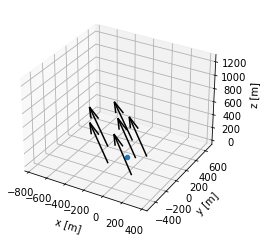

In [14]:
#3D display
ax = sub_array.display_3d()
fig = ax.scatter(sub_array.barycenter[0], sub_array.barycenter[1], sub_array.barycenter[2])
#plt.savefig("3d_0.png")

In [15]:
#tel dictionary with div pointing
tels_dict = {}
point_az_dict = {}
point_alt_dict = {}

for tel_id, tel in enumerate(array.telescopes, 1):
    
    tels_dict[tel_id] = {'az': tels_az[tel_id-1]*u.deg,
                     'alt': tels_alt[tel_id-1]*u.deg}
    point_az_dict[tel_id] = tels_az[tel_id-1] * u.rad
    point_alt_dict[tel_id] = tels_alt[tel_id-1] * u.rad

In [16]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.time import Time

#print(tels_az)

location = EarthLocation.of_site('Roque de los Muchachos')
obstime = Time('2013-11-01T03:00')
altaz = AltAz(location=location, obstime=obstime)

#Define pointing as a SkyCoord object
#tels_pointing = {}
#for tel_id, tel in enumerate(array.telescopes, 1):
#    tels_pointing[tel_id] = SkyCoord(alt=tel.alt,az=tel.az, frame=AltAz())
#print(tels_pointing)

tels_pointing = SkyCoord(alt=tels_alt,az=tels_az, frame=altaz, unit='rad')

#print(tels_pointing)

array_pointing = SkyCoord(alt=70, az=180, frame=altaz, unit='deg')
#print(array_pointing)

icrs_point = tels_pointing.transform_to(ICRS())
print(tels_pointing.transform_to(ICRS()))

gal_point = tels_pointing.galactic
#print(fk5_point)




<SkyCoord (ICRS): (ra, dec) in deg
    [(67.54146028, 8.91290095), (67.54146028, 8.91290095),
     (67.54146028, 8.91290095), (67.54146028, 8.91290095),
     (67.58957276, 8.2194141 ), (68.24682346, 8.44400771),
     (67.77641893, 9.05539587), (67.77641893, 9.05539587),
     (66.83674416, 9.18882017), (66.96866176, 8.55748909),
     (66.96866176, 8.55748909), (68.24682346, 8.44400771),
     (66.83674416, 9.18882017), (66.96866176, 8.55748909),
     (67.77641893, 9.05539587), (68.24682346, 8.44400771),
     (67.58957276, 8.2194141 ), (67.58957276, 8.2194141 ),
     (66.83674416, 9.18882017)]>


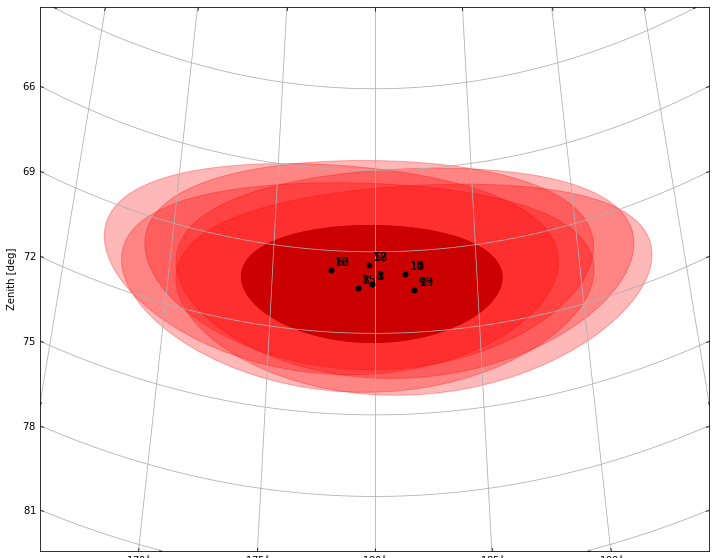

In [17]:
#WORKING
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist import Subplot
from mpl_toolkits.axisartist import SubplotHost, ParasiteAxesAuxTrans
from mpl_toolkits.axisartist.grid_helper_curvelinear import GridHelperCurveLinear
from matplotlib.projections import PolarAxes
from matplotlib.transforms import Affine2D
from astropy.visualization.wcsaxes import SphericalCircle

# PolarAxes.PolarTransform takes radian. However, we want our coordinate
# system in degree
tr = Affine2D().scale(np.pi/180., 1.).translate(+np.pi/2.,0) + PolarAxes.PolarTransform()

# polar projection, which involves cycle, and also has limits in
# its coordinates, needs a special method to find the extremes
# (min, max of the coordinate within the view).

# 20, 20 : number of sampling points along x, y direction
n = 20
extreme_finder = angle_helper.ExtremeFinderCycle(10, 10,
                                                 lon_cycle=360,
                                                 lat_cycle=None,
                                                 lon_minmax=None,
                                                 lat_minmax=(-90, 90),
                                                 )

grid_locator1 = angle_helper.LocatorDMS(12)
# Find a grid values appropriate for the coordinate (degree,
# minute, second).

tick_formatter1 = angle_helper.FormatterDMS()
# And also uses an appropriate formatter.  Note that,the
# acceptable Locator and Formatter class is a bit different than
# that of mpl's, and you cannot directly use mpl's Locator and
# Formatter here (but may be possible in the future).

grid_helper = GridHelperCurveLinear(tr,
                                    extreme_finder=extreme_finder,
                                    grid_locator1=grid_locator1,
                                    tick_formatter1=tick_formatter1
                                    )

fig = plt.figure(figsize=(12,10))
fig.clf()
ax1 = SubplotHost(fig, 1, 1, 1, grid_helper=grid_helper)

# make ticklabels of right and top axis visible.
ax1.axis["right"].major_ticklabels.set_visible(False)
ax1.axis["top"].major_ticklabels.set_visible(False)
ax1.axis["bottom"].major_ticklabels.set_visible(True)


fig.add_subplot(ax1)
# A parasite axes with given transform
ax2 = ParasiteAxesAuxTrans(ax1, tr, "equal")
# note that ax2.transData == tr + ax1.transData
# Anything you draw in ax2 will match the ticks and grids of ax1.
ax1.parasites.append(ax2)

for i, tel in enumerate(array.telescopes, 1):
    tel_altitude = tels_alt[i-1]
    tel_azimut = tels_az[i-1]
    tels_points = SkyCoord(alt=tel_altitude,az=tel_azimut, frame=altaz, unit='rad')
    x = tels_points.az.degree
    y = tels_points.alt.degree
    #print(x)
    if i <= 4:
        r = SphericalCircle((x * u.deg, y * u.deg), tel.camera_radius * u.degree, color='black', alpha=0.5, transform=ax2.transData)
    else:
        r = SphericalCircle((x * u.deg, y * u.deg), tel.camera_radius * u.degree, color='r', alpha=0.1, transform=ax2.transData)

    ax1.add_patch(r)
    ax2.annotate(i, (x, y), fontsize=12, xytext=(4, 4), textcoords='offset pixels', zorder=10)
    ax1.scatter(x, y, c = "black", s=20, transform=ax2.transData, zorder=10)

ax1.set_xlim(-20,20)
ax1.set_ylim(-80, -60)
#ax1.set_xlim(-181, 181)
#ax1.set_ylim(-91, 91)
ax1.set_aspect(1.)

ax1.grid(True)
ax1.set_xlabel("Azimuth [deg]", fontsize=20)
ax1.set_ylabel("Zenith [deg]", fontsize=20)


#plt.savefig("skymap_div{}.png".format(div))
plt.show()


In [18]:
from descartes import PolygonPatch
from shapely.ops import unary_union, polygonize
from shapely.geometry import mapping, Polygon, Point, LineString

polygons = {}
for ii, tel in enumerate(array.telescopes, 1):
  
    tel_alt = tels_alt[ii-1]
    tel_az = tels_az[ii-1]
    tels_points = SkyCoord(alt=tel_alt,az=tel_az, frame=altaz, unit='rad')
    polygons[ii-1] = Point(tels_points.az.degree, 90-tels_points.alt.degree).buffer(tel.camera_radius)

xrange = [168, 192]
yrange = [13, 28]


rings = [LineString(list(pol.exterior.coords)) for pol in polygons.values()]
union = unary_union(rings)
result = {counter:geom for counter, geom in enumerate(polygonize(union))}

ori = list(polygons.values())
res = list(result.values())



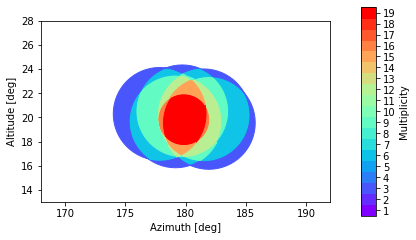

9.225198342901948 29.4337772185725 5.4252905192784375
81.88085540601372


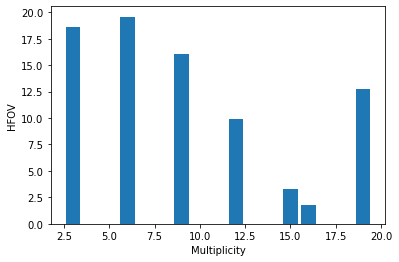

In [19]:
dict_count_overlaps = {}
for i in range(len(res)):
    dict_count_overlaps[i] = 0
    
    for j in range(len(ori)):
        if np.isclose(res[i].difference(ori[j]).area, 0):      
            dict_count_overlaps[i] +=1
            

max_multiplicity = max(dict_count_overlaps.values())
#print(max_multiplicity)

cmap = plt.cm.get_cmap('rainbow')
color_list = cmap(np.linspace(0, 1, max_multiplicity))
bounds = np.arange(max_multiplicity + 1) + 1

fig = plt.figure()
gs  = mpl.gridspec.GridSpec(1, 2, width_ratios=[0.95, 0.05])

ax = plt.subplot(gs[0])
ax_cb = plt.subplot(gs[1])

fig.subplots_adjust(top=0.85)

for pol_id, pol in result.items():
    colore = dict_count_overlaps[pol_id]
    ax.add_patch(
         PolygonPatch(mapping(pol), color=color_list[colore-1])
    )

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cb1 = mpl.colorbar.ColorbarBase(ax_cb,
                                 norm=norm,
                                 cmap=cmap,
                                 boundaries = bounds,
                                 orientation='vertical',
                                label='Multiplicity')
cb1.set_ticks(np.arange(max_multiplicity + 1) + 0.5)
cb1.set_ticklabels(np.arange(max_multiplicity + 1) + 1)

ax.set_xlabel("Azimuth [deg]")
ax.set_ylabel("Altitude [deg]")
ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
ax.set_aspect(1)
#plt.savefig("multiplicity_plot_div{}.png".format(div))
plt.show()

hfov = []
for patchsky in res:
     hfov.append(patchsky.area)
     #print(patchsky.area)

hfov = np.array(hfov) #hfov è generato come lista e viene qui convertito in array
# multiplicity associated with each patch
overlaps = np.array(list(dict_count_overlaps.values()))
average_overlap = np.average(overlaps, weights=hfov)
variance = np.average((overlaps-average_overlap)**2, weights=hfov)
print(average_overlap, variance, np.sqrt(variance))
print(hfov.sum())
plt.figure()
plt.bar(list(set(overlaps)), [hfov[overlaps==i].sum() for i in set(overlaps)])
plt.ylabel('HFOV')
plt.xlabel('Multiplicity')
#plt.savefig("multiplicity_chart_div{}.png".format(div))
plt.show()


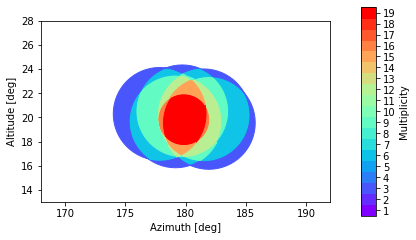

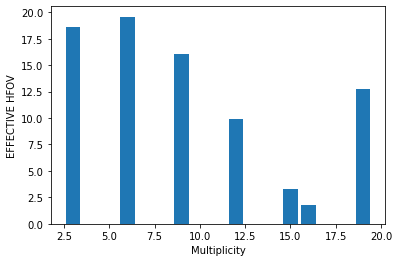

Average multiplicity: 9.225198342901948
variance: 29.4337772185725, std dev : 5.4252905192784375
Total HFoV : 81.88085540601372 deg2


In [20]:
eff_hfov=[]
eff_overlaps=[]
eff_res=[]
for i,patchsky in enumerate(res):
    if overlaps[i]>2:
        eff_overlaps.append(overlaps[i])
        eff_hfov.append(patchsky.area)
        eff_res.append(res[i])
        
eff_res=np.array(eff_res)
eff_hfov= np.array(eff_hfov) 
eff_overlaps= np.array(eff_overlaps) 
average_overlap = np.average(eff_overlaps, weights=eff_hfov)

cmap = plt.cm.get_cmap('rainbow')
color_list = cmap(np.linspace(0, 1, max_multiplicity))
bounds = np.arange(max_multiplicity + 1) + 1
fig = plt.figure()
gs  = mpl.gridspec.GridSpec(1, 2, width_ratios=[0.95, 0.05])

ax = plt.subplot(gs[0])
ax_cb = plt.subplot(gs[1])

fig.subplots_adjust(top=0.85)

    
for pol_id, pol in enumerate (eff_res):
    colore = eff_overlaps[pol_id]
    ax.add_patch(
         PolygonPatch(mapping(pol), color=color_list[colore-1])
    )


norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cb1 = mpl.colorbar.ColorbarBase(ax_cb,
                                 norm=norm,
                                 cmap=cmap,
                                 boundaries = bounds,
                                 orientation='vertical',
                                label='Multiplicity')
cb1.set_ticks(np.arange(max_multiplicity + 1) + 0.5)
cb1.set_ticklabels(np.arange(max_multiplicity + 1) + 1)
ax.set_xlabel("Azimuth [deg]")
ax.set_ylabel("Altitude [deg]")
ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
ax.set_aspect(1)
#plt.savefig("multiplicity_plot_div{}.png".format(div))
plt.show()


plt.figure()
plt.bar(list(set(eff_overlaps)), [eff_hfov[eff_overlaps==i].sum() for i in set(eff_overlaps)])
plt.ylabel('EFFECTIVE HFOV')
plt.xlabel('Multiplicity')
#plt.savefig("multiplicity_chart_div{}.png".format(div))
plt.show()
print(f'Average multiplicity: {average_overlap}') 
print(f'variance: {variance}, std dev : {np.sqrt(variance)}')
print(f'Total HFoV : {eff_hfov.sum()} deg2')


In [21]:
filename = 'divtel/CTA-ULTRA6-LaPalma-div-subarrays-{}.cfg'.format(div)

with open(filename, 'w') as f:
    f.write("""#ifndef TELESCOPE
# define TELESCOPE 0
#endif\n
#if TELESCOPE == 0\n""")
    f.write('   TELESCOPE_THETA={:.2f} \n'.format(90 - array_pointing.alt.value))
    f.write('   TELESCOPE_PHI={:.2f} \n'.format(array_pointing.az.value))
    f.write("""\n% Global and default configuration for things missing in telescope-specific config.
# include <CTA-ULTRA6-LST.cfg>\n""")
    for id, tel in enumerate(tels_pointing, 1):
        zd = 90 - tel.alt.value
        f.write('\n#elif TELESCOPE == {:d}\n'.format(id))
        if id <= 4:
            f.write('#  include <CTA-ULTRA6-LST.cfg>\n')
        else:
            f.write('#  include <CTA-ULTRA6-MST-NectarCam.cfg>\n')
        f.write('   TELESCOPE_THETA={:.2f}\n'.format(zd))
        f.write('   TELESCOPE_PHI={:.2f}\n'.format(tel.az.value))
    f.write("""
#else\n
    Error Invalid telescope for CTA-ULTRA6 La Palma configuration.\n
#endif\n
trigger_telescopes = 2 % In contrast to Prod-3 South we apply loose stereo trigger immediately
array_trigger = array_trigger_ultra6_diver-test.dat""")
f.close()

In [22]:
#check cfg file
with open(filename, 'r') as f:
        print(f.read())

#ifndef TELESCOPE
# define TELESCOPE 0
#endif

#if TELESCOPE == 0
   TELESCOPE_THETA=20.00 
   TELESCOPE_PHI=180.00 

% Global and default configuration for things missing in telescope-specific config.
# include <CTA-ULTRA6-LST.cfg>

#elif TELESCOPE == 1
#  include <CTA-ULTRA6-LST.cfg>
   TELESCOPE_THETA=19.82
   TELESCOPE_PHI=179.86

#elif TELESCOPE == 2
#  include <CTA-ULTRA6-LST.cfg>
   TELESCOPE_THETA=19.82
   TELESCOPE_PHI=179.86

#elif TELESCOPE == 3
#  include <CTA-ULTRA6-LST.cfg>
   TELESCOPE_THETA=19.82
   TELESCOPE_PHI=179.86

#elif TELESCOPE == 4
#  include <CTA-ULTRA6-LST.cfg>
   TELESCOPE_THETA=19.82
   TELESCOPE_PHI=179.86

#elif TELESCOPE == 5
#  include <CTA-ULTRA6-MST-NectarCam.cfg>
   TELESCOPE_THETA=20.51
   TELESCOPE_PHI=179.73

#elif TELESCOPE == 6
#  include <CTA-ULTRA6-MST-NectarCam.cfg>
   TELESCOPE_THETA=20.30
   TELESCOPE_PHI=177.85

#elif TELESCOPE == 7
#  include <CTA-ULTRA6-MST-NectarCam.cfg>
   TELESCOPE_THETA=19.68
   TELESCOPE_PHI=179.17

#elif TELESCOPE